# Landslide Prevention and Innovation Challenge with common scikit-learn libraries

In [ ]:
import lightgbm as lgb
if not lgb.__version__ =='3.3.2':
  print('You must install LightGBM 3.3.2')
  !pip install lightgbm==3.3.2 --install-option=--gpu

In [ ]:
#Import libraries

import pandas as pd
import numpy as np
import random
import itertools
from functools import partial
import os
import sys
import gc

import sklearn
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Versions

In [ ]:
def print_ver(m):
  print(f' {m.__name__} version: {m.__version__}')  
print_ver(np)
print_ver(pd)
print_ver(lgb)
print_ver(sklearn)

 numpy version: 1.21.6
 pandas version: 1.3.5
 lightgbm version: 3.3.2
 sklearn version: 1.0.2


## Load Data

In [ ]:
def seed_everything(seed=55):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
my_seed=55
seed_everything(my_seed)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# read data from https://zindi.africa/competitions/landslide-prevention-and-innovation-challenge/data
# please locate data according to your current setup
path = '/content/drive/MyDrive/ColabNotebooks/Zindi_LPI/'
path="../input/start-hack-22/"
train = pd.read_csv(path+'Train.csv', index_col=0)
test = pd.read_csv(path+'Test.csv',index_col=0)
sample_submission = pd.read_csv(path+'SampleSubmission.csv')
y_train=train['Label'].values

In [ ]:
# create strafied train, validation sets
strat_train_set, strat_test_set=train_test_split(train, test_size=0.2, stratify=train['Label'],random_state=my_seed)
strat_train_label=strat_train_set['Label']
strat_test_label=strat_test_set['Label']
strat_train_set.drop('Label',axis=1,inplace=True)
strat_test_set.drop('Label',axis=1,inplace=True)
train.drop('Label',axis=1,inplace=True)

# Explorary Data Analysis 

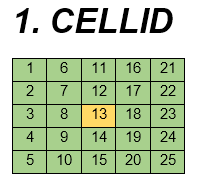


Each sample is composed of data from 25 cells, covering an area of 625 m2. Each cell represents an area of 5 x 5 m2 and has nine features (as introduced in section 2). For a landslide sample, cell 13 is the location of landslide, and other cells are the neighboring areas. For a non-landslide sample, there is no recorded landslide occurrence within the sample area.


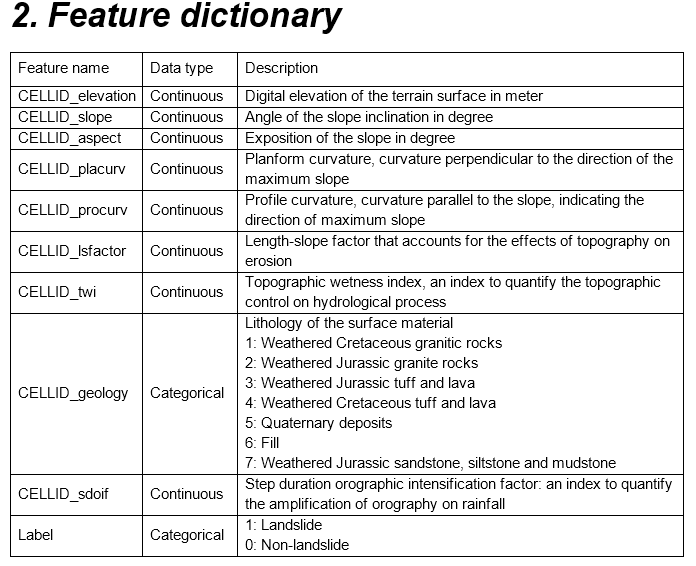

For further analysis, please refer my other notebook [here](https://www.kaggle.com/code/denizstij/eda-landslide-prevention-and-innovation/notebook)

# Feature Engineering

In [ ]:
base_num_features=['elevation',  'lsfactor', 'placurv', 'procurv', 'sdoif', 'slope', 'twi', 'aspect']
base_cat_features=['geology']
raw_num_features=[x for x in strat_train_set.columns for col in base_num_features if col in x] 
raw_cat_features=[x for x in strat_train_set.columns if 'geology' in x] 

diag_lr_col_index=[[1,7,13,19,25],[2,8,14,20],[6,12,18,24]]
diag_rl_col_index=[[21,17,13,9,5],[16,12,8,4],[22,18,14,10]]
corn_col_index=[1,21,5,25]
imp_colum_index=diag_lr_col_index+diag_rl_col_index+[corn_col_index] ## import columns 
gradient_cols=['placurv', 'procurv']

In [ ]:
class CategoricalTransformer(TransformerMixin, BaseEstimator):
    
    def fit(self, x, y=None):    
        return self    

    def transform(self, x, y=None):
        self.feature_names=[]
        print(f'starting categorical feature with input shape: {x.shape}')
        self.feature_names.extend(raw_cat_features)        
        df = pd.DataFrame(x, columns=raw_cat_features)
        #df[raw_cat_features]=df[raw_cat_features].astype("category")
        
        col_name=f'geology_nunique'
        self.feature_names.append(col_name)
        df[col_name]=df.nunique(axis=1)
      
        for i in range(1,8):    
            col_name=f'geology_cat_{i}_nunique'
            mask=df.loc[:,raw_cat_features]==i
            self.feature_names.append(col_name)
            df[col_name]= mask.sum(axis=1)
            for ii, idx in enumerate(imp_colum_index):
                diag_col_names=[str(x)+"_geology" for x in idx ]
                col_name=f'geology_cat_{i}_{ii+1}_nunique_imp_idx'
                self.feature_names.append(col_name)
                mask=df.loc[:,diag_col_names]==i
                df[col_name]= mask.sum(axis=1)            
        
        col_name=f'geology_mode'
        self.feature_names.append(col_name)
        df[col_name]=df.loc[:,raw_cat_features].mode(axis=1)[0].astype('int8')
        #df[col_name]=df[col_name].astype("category")
        
        #print(f'{col_name} shape {df.shape}')
        return df[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names

In [ ]:
class NumericalTransformer(TransformerMixin, BaseEstimator):            
    def fit(self, x, y=None):        
        return self    

    def transform(self, x, y=None):
        self.feature_names=[]
        print(f'starting numerical feature with input shape: {x.shape}')
        self.feature_names.extend(raw_num_features)        
        df = pd.DataFrame(x, columns=raw_num_features)
        res = df.copy()
        
        sum_prod_cur=None
        for i in range(1,26):
            curve_col_names=[str(i)+"_"+ x for x in gradient_cols]     
            col_name=f'curve_{i}_mean'
            self.feature_names.append(col_name)
            res[col_name] = df.loc[:,curve_col_names].mean(axis = 1)    
            col_name=f'curve_{i}_sum'
            self.feature_names.append(col_name)
            res[col_name] = df.loc[:,curve_col_names].sum(axis = 1)    
            col_name=f'curve_{i}_diff'
            self.feature_names.append(col_name)
            res[col_name] = df.loc[:,curve_col_names].diff(axis = 1).iloc[:,1] 
            placurv_col_name=f'{i}_placurv'
            procurv_col_name=f'{i}_procurv'
            if sum_prod_cur is None:
                sum_prod_cur=df.loc[:,placurv_col_name]*df.loc[:,procurv_col_name]
            else:
                sum_prod_cur=sum_prod_cur+ df.loc[:,placurv_col_name]*df.loc[:,procurv_col_name]
    
        col_name=f'sum_prod_curve'
        self.feature_names.append(col_name)
        res[col_name]=sum_prod_cur
        #print(f'sum_prod_curve new shape {res.shape}')
        # numerical
        for i, col in enumerate(base_num_features):
            col_names=[x for x in df.columns if col in x]
            #print(f'{col} new shape {res.shape}')
            col_name=f'{col}_mean'
            self.feature_names.append(col_name)
            res[col_name] = df[col_names].mean(axis = 1)        
            col_name=f'{col}_std'
            self.feature_names.append(col_name)
            res[col_name] = df[col_names].std(axis = 1)

            # Given that cell 13 is most important, lets look into diff and ratio
            col_name=f'13_{col}'
            d13_col_names=[f'{col}_13_sub_{i}' for i in range(25)]
            self.feature_names.extend(d13_col_names)
            res[d13_col_names] = df.loc[:,col_names].subtract(df.loc[:,col_name], axis=0 )
            d13_col_names=[f'{col}_13_div_{i}' for i in range(25)]
            self.feature_names.extend(d13_col_names)
            res[d13_col_names] = df.loc[:,col_names].div(df.loc[:,col_name], axis=0 )        

            col_names=[x for x in df.columns if col in x]        
            res_col_name=[f'{ii}_{col}_rank' for ii in range(1,26)]        
            self.feature_names.extend(res_col_name)
            res[res_col_name]= df[col_names].rank(axis = 1, method='min').astype('int8')
            

            for ii, idx in enumerate(diag_lr_col_index):
                col_name=f'diag_lr{ii}_mean_{col}'
                diag_col_names=[str(x)+"_"+col for x in idx ]
                self.feature_names.append(col_name)
                res[col_name]=df.loc[:,diag_col_names].diff(axis=1).mean(axis=1)
                col_name=f'diag_lr{ii}_std_{col}'
                self.feature_names.append(col_name)
                res[col_name]=df.loc[:,diag_col_names].diff(axis=1).std(axis=1)
                col_name=f'diag_lr{ii}_sum_{col}'
                self.feature_names.append(col_name)
                res[col_name]=df.loc[:,diag_col_names].sum(axis=1)

            for ii, idx in enumerate(diag_rl_col_index):
                col_name=f'diag_rl{ii}_mean_{col}'
                diag_col_names=[str(x)+"_"+ col for x in idx ]        
                self.feature_names.append(col_name)
                res[col_name]=df.loc[:,diag_col_names].diff(axis=1).mean(axis=1)
                col_name=f'diag_rl{ii}_std_{col}'
                self.feature_names.append(col_name)
                res[col_name]=df.loc[:,diag_col_names].diff(axis=1).std(axis=1)
                col_name=f'diag_rl{ii}_sum_{col}'
                self.feature_names.append(col_name)
                res[col_name]=df.loc[:,diag_col_names].sum(axis=1)
                    
            col_name=f'corner_mean_{col}'
            diag_col_names=[str(x)+"_"+ col for x in corn_col_index ]        
            self.feature_names.append(col_name)
            res[col_name]=df.loc[:,diag_col_names].diff(axis=1).mean(axis=1)

            col_name=f'corner_std_{col}'
            self.feature_names.append(col_name)
            res[col_name]=df.loc[:,diag_col_names].diff(axis=1).std(axis=1)

            col_name=f'corner_sum_{col}'
            self.feature_names.append(col_name)
            res[col_name]=df.loc[:,diag_col_names].sum(axis=1)

            col_name=f'grad1_{col}'     
            self.feature_names.append(col_name)
            res[col_name]=df.apply(lambda x: (x['1_'+col]/x['5_'+col]), axis=1)        

            col_name=f'grad2_{col}'
            self.feature_names.append(col_name)
            res[col_name]=df.apply(lambda x: (x['1_'+col]/x['21_'+col]), axis=1)

            col_name=f'grad3_{col}'
            self.feature_names.append(col_name)
            res[col_name]=df.apply(lambda x: (x['5_'+col]/x['25_'+col]), axis=1)

            col_name=f'grad4_{col}'
            self.feature_names.append(col_name)
            res[col_name]=df.apply(lambda x: (x['21_'+col]/x['25_'+col]), axis=1)

            #print(f'{col} new shape {res.shape}')

            # diff 1 and 2 features on axis 1 and 2 
            arr=df.loc[:,col_names].values.reshape(len(df),5,5)        
            arr=arr.astype('float32')
            d1=np.mean(arr,axis=1)
            d2=np.mean(arr,axis=2)
            d3=np.std(arr,axis=1)
            d4=np.std(arr,axis=2)
            d5=np.diff(arr,axis=1).mean(axis=1)
            d6=np.diff(arr,axis=2).mean(axis=2)

            d11=np.mean(arr,axis=1)
            d12=np.mean(arr,axis=2)
            d21=np.mean(d2,axis=1)
            d22=np.mean(d2,axis=1)
            deltas={'d1':d1,'d2':d2,'d3':d3,'d4':d4,'d5':d5,'d6':d6,'d11':d11,'d12':d12,'d21':d21,'d22':d22}

            for delta_col, d in deltas.items():            
                dx=d.reshape(len(df),-1).astype('float32')                        
                dx_col_names=[f'{col}_{delta_col}_{i}' for i in range(dx.shape[1])]            
                self.feature_names.extend(dx_col_names)
                res[dx_col_names]=dx            

            #print(f'{col} new shape {res.shape} features length: {len(self.feature_names)}')
    
        return res[self.feature_names]
    
    def get_feature_names(self):
        return self.feature_names

In [ ]:
preprocessing=make_column_transformer(
    (CategoricalTransformer(), raw_cat_features), #make_column_selector(pattern="[09]*_geology")#),    
    (NumericalTransformer(), raw_num_features), #make_column_selector(pattern="[09]*_geology")#),    
    remainder='passthrough',
    verbose=True
)

In [ ]:
print("**** Training Feature Eng ****")
train_features=preprocessing.fit_transform(train)
print("**** Stratified Training Feature Eng ****")
strat_train_features=preprocessing.fit_transform(strat_train_set)
print("**** Stratified Testing Feature Eng ****")
strat_test_features=preprocessing.transform(strat_test_set)
print("**** Testing Feature Eng ****")
test_features=preprocessing.transform(test)

**** Training Feature Eng ****
starting categorical feature with input shape: (10864, 25)
[ColumnTransformer]  (1 of 2) Processing categoricaltransformer, total=   5.4s
starting numerical feature with input shape: (10864, 200)
[ColumnTransformer]  (2 of 2) Processing numericaltransformer, total=   7.0s
**** Stratified Training Feature Eng ****
starting categorical feature with input shape: (8691, 25)
[ColumnTransformer]  (1 of 2) Processing categoricaltransformer, total=   4.2s
starting numerical feature with input shape: (8691, 200)
[ColumnTransformer]  (2 of 2) Processing numericaltransformer, total=   5.7s
**** Stratified Testing Feature Eng ****
starting categorical feature with input shape: (2173, 25)
starting numerical feature with input shape: (2173, 200)
**** Testing Feature Eng ****
starting categorical feature with input shape: (5430, 25)
starting numerical feature with input shape: (5430, 200)


In [ ]:
df_train=pd.DataFrame(train_features, columns=preprocessing.get_feature_names(), index= train.index)
df_strat_train=pd.DataFrame(strat_train_features, columns=preprocessing.get_feature_names(), index= strat_train_set.index)
df_strat_test=pd.DataFrame(strat_test_features,columns=preprocessing.get_feature_names(), index= strat_test_set.index)
df_test=pd.DataFrame(test_features,columns=preprocessing.get_feature_names(), index=test.index)

print(f" df_train shape: {df_train.shape} df_strat_train shape: {df_strat_train.shape}  df_strat_test.shape {df_strat_test.shape} df_test.shape {df_test.shape}  ")

 df_train shape: (10864, 1511) df_strat_train shape: (8691, 1511)  df_strat_test.shape (2173, 1511) df_test.shape (5430, 1511)  


In [ ]:
all_column_names=df_strat_train.columns.to_list()

cat_rank_features=[x for x in all_column_names if "_rank" in x]
wanted_cat_features= raw_cat_features + ['geology_mode']
new_cat_features=[x for x in all_column_names for c in wanted_cat_features if c in x]
all_cat_features=new_cat_features+cat_rank_features
print(f"# all features : {len(all_column_names)} # cat feature : {len(all_cat_features)}")
#all_cat_features ,all_column_names

# all features : 1511 # cat feature : 240


## Todo
Reduce the number of features.

# Model Training with LightGBM and DART 

In [ ]:
def lgb_f1_score(y_true, y_hat):        
    #print(f"y_hat: {y_hat} y_true: {y_true} ")    
    y_hat=np.where(y_hat>0.5,1,0)
    scr=f1_score(y_true, y_hat)    
    return 'f1', f1_score(y_true, y_hat), True

def f1_score_with_threshold(y_true, y_hat, thrshold=0.5):
    #y_hat=y_hat>thrshold
    y_hat=np.where(y_hat>thrshold,1,0)    
    return f1_score(y_true, y_hat)

In [ ]:
def create_classifier(num_iter=1000):    
    params = {
        'force_col_wise':True, # memory foot print is smaller
        'n_estimators':num_iter,
        'objective': 'binary',
        'metric': "binary_logloss",
        'boosting_type': 'dart',
        'max_depth' : -1,
        'random_state': my_seed,        
        'learning_rate': 0.01,
        'num_leaves': 2 ** 6, 
        'min_data_in_leaf': 15,
        'subsample': 0.8,  
        'subsample_freq': 1,
        'first_metric_only': True,
        'boost_from_average': False,
        'tree_learner': 'serial',        
        #'verbose': -1,
        
    } 
    classifier= Pipeline([#('preprocessing', preprocessing),                      
                         ('clazzifier',lgb.LGBMClassifier(**params))],
                        verbose=False)                      
    return classifier

### Cross validation

In [ ]:
from sklearn.model_selection import cross_validate, cross_val_predict
# CV 
def apply_cross_validation(num_iter=100,cv=5):
    seed_everything()
    classifier=create_classifier(num_iter)
    
    lgb_valid = [(df_strat_train,strat_train_label),
                 (df_strat_test, strat_test_label)]
    fit_params={'clazzifier__eval_set':lgb_valid, 
                'clazzifier__eval_metric':[lgb_f1_score],
                'clazzifier__feature_name':all_column_names,
                'clazzifier__categorical_feature':all_cat_features,
                'clazzifier__verbose':0
               }
    print(f"Applying CV: {cv} num_iter: {num_iter} ")
    #res=cross_validate(classifier,df_strat_train,strat_train_label, scoring='f1', cv=cv, verbose=1)    
    oof_probs=cross_val_predict(classifier,df_strat_train,strat_train_label, 
                                fit_params=fit_params,
                                method='predict_proba',
                                cv=cv)    
    return classifier,oof_probs
classifier,oof_probs=apply_cross_validation(num_iter=1000,cv=5)
oof_probs

Applying CV: 5 num_iter: 1000 
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


array([[0.41932014, 0.58067986],
       [0.5818949 , 0.4181051 ],
       [0.94315352, 0.05684648],
       ...,
       [0.83561185, 0.16438815],
       [0.5240518 , 0.4759482 ],
       [0.86719886, 0.13280114]])

### Finding most optimum F1 Score/classification threshold with OoO Fold probabilities

max_idx: 35 max_ths: 0.3535353535353536 max: 0.7063180827886711


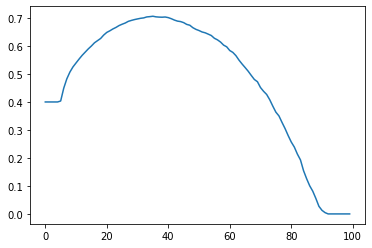

In [ ]:
thrs=np.linspace(0,1, num=100)

f1_curve=[f1_score_with_threshold (strat_train_label.values, oof_probs[:,1], t) for t in thrs  ]
plt.plot(f1_curve)
max_idx=np.argmax(f1_curve)
max_ths=thrs[max_idx]
print(f"max_idx: {max_idx} max_ths: {max_ths} max: {f1_curve[max_idx]}",)

In [ ]:
score_f1=f1_score_with_threshold(strat_train_label.values,  oof_probs[:,1],max_ths )
print(f"OoO score_f1: {score_f1}")

OoO score_f1: 0.7063180827886711


### Plot Confusion Matrix

max_ths: 0.3535353535353536


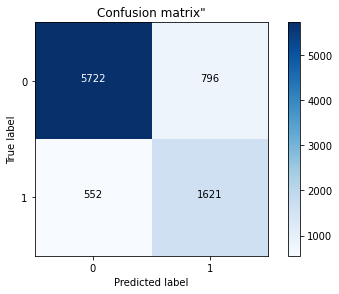

In [ ]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
print(f"max_ths: {max_ths}")
oof_predictions_prob=np.where(oof_probs[:,1]>max_ths,1,0)
cm = confusion_matrix(strat_train_label.values, oof_predictions_prob)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, classes = class_names)
plt.show()

### Run classifier on the test validation set

In [ ]:
# check out f1 score
def run_test_validation(num_iter=2000):
    seed_everything()
    classifier=create_classifier(num_iter)
    lgb_valid = [(df_strat_train,strat_train_label),
                 (df_strat_test, strat_test_label)]
    print(f"\n*** Training classifier num_iter: {num_iter}")
    classifier.fit(df_strat_train,strat_train_label, #strat_train_set,strat_train_label, 
                   clazzifier__eval_set =lgb_valid, clazzifier__eval_metric =[lgb_f1_score],
                   clazzifier__feature_name=all_column_names,
                   clazzifier__categorical_feature=all_cat_features,
                   clazzifier__verbose=0)
    
    print(f"\n*** Predicting validation test set num_iter : {num_iter}")
    strat_test_hat=classifier.predict_proba(df_strat_test)
    strat_test_f1=lgb_f1_score(strat_test_label.values, strat_test_hat[:,1])
    print(f"strat_test_f1: {strat_test_f1}")
    return classifier,strat_test_hat

classifier, strat_test_hat=run_test_validation(num_iter=5000)


*** Training classifier num_iter: 5000
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15

*** Predicting validation test set num_iter : 5000
strat_test_f1: ('f1', 0.6892895015906682, True)


max_idx: 1 max_ths: 0.1111111111111111 max: 0.7221324717285946


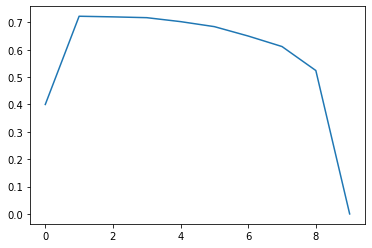

In [ ]:
thrs=np.linspace(0,1, num=10)

f1_curve_strat_test=[f1_score_with_threshold (strat_test_label.values, strat_test_hat[:,1], t) for t in thrs  ]
plt.plot(f1_curve_strat_test)
max_idx_strat_test=np.argmax(f1_curve_strat_test)
max_ths_strat_test=thrs[max_idx_strat_test]
print(f"max_idx: {max_idx_strat_test} max_ths: {max_ths_strat_test} max: {f1_curve_strat_test[max_idx_strat_test]}",)

In [ ]:
score_f1=f1_score_with_threshold(strat_test_label.values,  strat_test_hat[:,1],max_ths_strat_test )
print(f"stratified test score_f1: {score_f1}")

stratified test score_f1: 0.7221324717285946


### Analyse feature importance

In [ ]:
def  analyse_model(model,desc, raw_numer=10, plot=False):
    print(desc)
    fi=pd.DataFrame({'Feature':df_train.columns,'importance':model.feature_importances_})
    fi.sort_values('importance',ascending=False, inplace=True)

    if plot:
        ax=sns.barplot(y='Feature',x='importance',data=fi)
        plt.xticks(rotation=90)
    
    print(fi.head(raw_numer))
    return fi
model=classifier[0]
fi=analyse_model(model, "strat test")

strat test
                                                Feature  importance
1483                  numericaltransformer__aspect_d3_4        1728
258                       numericaltransformer__1_sdoif        1652
116                       numericaltransformer__9_slope        1534
115                       numericaltransformer__8_slope        1487
1160           numericaltransformer__diag_lr1_std_slope        1293
1138                 numericaltransformer__8_slope_rank        1275
584         numericaltransformer__diag_lr1_std_lsfactor        1120
46    categoricaltransformer__geology_cat_3_4_nuniqu...        1046
1223                     numericaltransformer__twi_mean        1042
360                 numericaltransformer__elevation_std        1037


### Train classifier with all training data 

In [ ]:
seed_everything()
classifier=create_classifier(num_iter=10000)
lgb_valid = [(df_train,y_train)]
classifier.fit(df_train,y_train,
               clazzifier__eval_set =lgb_valid, clazzifier__eval_metric =[lgb_f1_score],
               clazzifier__feature_name=all_column_names,
               clazzifier__categorical_feature=all_cat_features,
              clazzifier__verbose=0)

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


Pipeline(steps=[('clazzifier',
                 LGBMClassifier(boost_from_average=False, boosting_type='dart',
                                first_metric_only=True, force_col_wise=True,
                                learning_rate=0.01, metric='binary_logloss',
                                min_data_in_leaf=15, n_estimators=10000,
                                num_leaves=64, objective='binary',
                                random_state=55, subsample=0.8,
                                subsample_freq=1, tree_learner='serial'))])

# Predicting Test Results

In [ ]:
all_test_prob=classifier.predict_proba(df_test)
all_test_prediction=np.where(all_test_prob[:,1]>max_ths_strat_test,1,0) 

In [ ]:
np.histogram(all_test_prediction, bins=2)

(array([3627, 1803]), array([0. , 0.5, 1. ]))

### Preparing Submission file

In [ ]:
def sub_files(file_name, test_result):    
    if max(test_result)>1 or min(test_result)<0 :
        print(f'invalid file : {file_name} due to boundary')
        return 
    if sum(test_result==0)==len(test):
        print(f'invalid file : {file_name} as all prediction is 0')
        return 
    
    if sum(test_result==1)==len(test):
        print(f'invalid file : {file_name} as all prediction is 1')
        return 
        
    df_sub_file = pd.DataFrame({'Sample_ID': test.index, 'Label': test_result})    
    print(df_sub_file.head())
    # Create a csv file and upload to zindi 
    #sub_file_name=path+f'{file_name}_f1_score_{score_f1}.csv'
    sub_file_name=f'{file_name}_f1_score_{score_f1}.csv'
    print(f'Saving to {sub_file_name}')
    df_sub_file.to_csv(sub_file_name, index = False)    

In [ ]:
sub_files('test_result',all_test_prediction)

   Sample_ID  Label
0      10865      0
1      10866      0
2      10867      0
3      10868      1
4      10869      1
Saving to test_result_f1_score_0.7221324717285946.csv
